<center><h2>Testing the Functionality of the <i>"utils.py"</i> Module</h2></center>

In [24]:
""" Tetsing the following functionality: 
    * metrics (rmsd, gdt_ts, gdt_ha, tmscore)
    * alignment (kabsch)
    * 3d coords (mds)
    -----
    The data files used contain the id of the original
    crystal structures from the RCSB PDB
"""

' Tetsing the following functionality: \n    * metrics (rmsd, gdt_ts, gdt_ha, tmscore)\n    * alignment (kabsch)\n    * 3d coords (mds)\n    -----\n    The data files used contain the id of the original\n    crystal structures from the RCSB PDB\n'

In [2]:
import os
import sys
# science
import numpy as np
import torch
import matplotlib.pyplot as plt
# molecular utils
import mdtraj
# functionality
sys.path.append("../")
from alphafold2_pytorch.utils import *

In [3]:
# load pdb file - has 1 more N_term than it should
prot = mdtraj.load_pdb("data/1h22_protein_chain_1.pdb").xyz[0].transpose()

## Metrics

In [4]:
# alter a small amount and measure metrics
pred = prot + (2*np.random.rand(*prot.shape) - 1) * 1

In [5]:
# Numpy
rmsd     = RMSD(prot, pred)
gdt_ha   = GDT(prot, pred, mode="HA")
gdt_ts   = GDT(prot, pred, mode="TS")
tm_score = TMscore(prot, pred)

print("rmsd is: ", rmsd)
print("gdt_ha is: ", gdt_ha)
print("gdt_ts is: ", gdt_ts)
print("tm_score is: ", tm_score)

# Torch
prot, pred = torch.tensor(prot), torch.tensor(pred)
rmsd     = RMSD(prot, pred)
gdt_ha   = GDT(prot, pred, mode="HA")
gdt_ts   = GDT(prot, pred, mode="TS")
tm_score = TMscore(prot, pred)

print("rmsd is: ", rmsd)
print("gdt_ha is: ", gdt_ha)
print("gdt_ts is: ", gdt_ts)
print("tm_score is: ", tm_score)

rmsd is:  [0.57641759]
gdt_ha is:  [0.64743763]
gdt_ts is:  [0.88115307]
tm_score is:  [0.99801202]
rmsd is:  tensor([0.5764], dtype=torch.float64)
gdt_ha is:  tensor([0.6474])
gdt_ts is:  tensor([0.8812])
tm_score is:  tensor([0.9980], dtype=torch.float64)


## Alignment

In [6]:
prot = prot.cpu().numpy()
pred = pred.cpu().numpy()

In [7]:
# rotation matrix
R = np.array([[0.25581, -0.77351, 0.57986],
              [-0.85333, -0.46255, -0.24057],
              [0.45429, -0.43327, -0.77839]])

In [8]:
# perturb protein (translation + rotation + random)
pred = prot + (2*np.random.rand(*prot.shape) - 1) * 1 
pred = np.dot(R, pred)

In [9]:
# check realignment works - torch
pred_mod_, prot_mod_ = kabsch_torch(torch.tensor(pred).double(), torch.tensor(prot).double())
rmsd_torch(prot_mod_, pred_mod_), tmscore_torch(prot_mod_, pred_mod_)

(tensor(0.5781, dtype=torch.float64), tensor(0.1680, dtype=torch.float64))

In [10]:
# check realignment works - numpy
pred_mod, prot_mod = kabsch_numpy(pred, prot)
rmsd_numpy(prot_mod, pred_mod), tmscore_numpy(prot_mod, pred_mod)

(0.5780659817276024, 0.167956858418738)

## 3d Converter

In [11]:
prot_traj = mdtraj.load_pdb("data/1h22_protein_chain_1.pdb")

In [12]:
prot = prot_traj.xyz[0].transpose()

In [13]:
# works with a simple distance matrix for now
prot = torch.tensor(prot)
dist_mat = torch.cdist(prot.t(), prot.t())

In [14]:
# plt.imshow(distogram, cmap="viridis_r")

In [15]:
# select indices of backbone for angle calculation and selection
N_mask  = torch.tensor( prot_traj.topology.select("name == N and backbone") ).unsqueeze(0)
CA_mask = torch.tensor( prot_traj.topology.select("name == CA and backbone") ).unsqueeze(0) 
C_mask  = torch.tensor( prot_traj.topology.select("name == C and backbone")  ).unsqueeze(0)
CA_mask.shape, N_mask.shape, C_mask.shape

(torch.Size([1, 482]), torch.Size([1, 482]), torch.Size([1, 482]))

In [20]:
sample = torch.cat([dist_mat.cpu().unsqueeze(0)]*1, dim=0)
sample.requires_grad = True
preds, stresses = MDScaling(sample,
                            iters=50, tol=1e-5, fix_mirror=1, # eigen=True,
                            N_mask=N_mask, CA_mask=CA_mask, C_mask=C_mask, verbose=2)

it: 0, stress tensor([1.1225e+08], grad_fn=<MulBackward0>)
it: 1, stress tensor([56343384.], grad_fn=<MulBackward0>)
it: 2, stress tensor([51373312.], grad_fn=<MulBackward0>)
it: 3, stress tensor([48811872.], grad_fn=<MulBackward0>)
it: 4, stress tensor([47531168.], grad_fn=<MulBackward0>)
it: 5, stress tensor([46875780.], grad_fn=<MulBackward0>)
it: 6, stress tensor([46521084.], grad_fn=<MulBackward0>)
it: 7, stress tensor([46314308.], grad_fn=<MulBackward0>)
it: 8, stress tensor([46179616.], grad_fn=<MulBackward0>)
it: 9, stress tensor([46075668.], grad_fn=<MulBackward0>)
it: 10, stress tensor([45977552.], grad_fn=<MulBackward0>)
it: 11, stress tensor([45868520.], grad_fn=<MulBackward0>)
it: 12, stress tensor([45734740.], grad_fn=<MulBackward0>)
it: 13, stress tensor([45562076.], grad_fn=<MulBackward0>)
it: 14, stress tensor([45334112.], grad_fn=<MulBackward0>)
it: 15, stress tensor([45030676.], grad_fn=<MulBackward0>)
it: 16, stress tensor([44626944.], grad_fn=<MulBackward0>)
it: 17

In [21]:
preds.mean().backward()
sample.grad

tensor([[[ 0.0000e+00,  6.1192e-09,  2.6883e-09,  ..., -7.8402e-09,
          -1.2692e-10, -7.2127e-09],
         [-6.1192e-09,  0.0000e+00, -8.2687e-09,  ..., -8.9109e-09,
          -2.7819e-09, -8.7419e-09],
         [-2.6883e-09,  8.2688e-09,  0.0000e+00,  ..., -8.5898e-09,
          -7.0206e-10, -8.1828e-09],
         ...,
         [ 7.8401e-09,  8.9109e-09,  8.5898e-09,  ...,  0.0000e+00,
           6.3062e-09,  1.8284e-09],
         [ 1.2695e-10,  2.7818e-09,  7.0211e-10,  ..., -6.3061e-09,
           0.0000e+00, -6.7814e-09],
         [ 7.2126e-09,  8.7419e-09,  8.1828e-09,  ..., -1.8284e-09,
           6.7815e-09,  0.0000e+00]]])

In [17]:
preds.mean().backward()
sample.grad

tensor([[[-0.0000e+00,  8.0342e-03, -6.3801e-03,  ..., -1.9747e-01,
          -1.8387e-01,  1.1395e-01],
         [-1.4394e-04, -0.0000e+00,  2.6821e-06,  ...,  4.8150e-05,
           1.0731e-04, -6.8197e-05],
         [-1.0513e-03,  3.8257e-06,  0.0000e+00,  ..., -1.3700e-04,
           1.7580e-04, -1.9789e-04],
         ...,
         [-3.2492e-04, -4.6058e-05,  2.4173e-05,  ...,  0.0000e+00,
           4.7417e-06, -2.7610e-06],
         [ 8.8929e-04, -9.7029e-05,  6.2248e-06,  ...,  7.8093e-06,
           0.0000e+00, -1.6475e-06],
         [ 1.5263e-03, -6.9711e-05,  3.9279e-06,  ...,  5.7547e-06,
           6.1176e-07, -0.0000e+00]]])

In [19]:
preds, stresses = MDScaling(torch.cat([dist_mat.cpu().unsqueeze(0)]*1, dim=0),
                            iters=10, tol=1e-5, fix_mirror=1,
                            N_mask=N_mask, CA_mask=CA_mask, C_mask=C_mask, verbose=2)

it: 0, stress tensor([1.1152e+08])
it: 1, stress tensor([56104596.])
it: 2, stress tensor([51176800.])
it: 3, stress tensor([48674864.])
it: 4, stress tensor([47427816.])
it: 5, stress tensor([46772392.])
it: 6, stress tensor([46397636.])
it: 7, stress tensor([46155412.])
it: 8, stress tensor([45969724.])
it: 9, stress tensor([45796812.])
it: 10, stress tensor([45608376.])
it: 11, stress tensor([45382128.])
it: 12, stress tensor([45096744.])
it: 13, stress tensor([44729080.])
it: 14, stress tensor([44252712.])
it: 15, stress tensor([43637248.])
it: 16, stress tensor([42848764.])
it: 17, stress tensor([41850924.])
it: 18, stress tensor([40607208.])
it: 19, stress tensor([39084876.])
it: 20, stress tensor([37260368.])
it: 21, stress tensor([35125392.])
it: 22, stress tensor([32693424.])
it: 23, stress tensor([30004392.])
it: 24, stress tensor([27124824.])
it: 25, stress tensor([24146340.])
it: 26, stress tensor([21174760.])
it: 27, stress tensor([18318620.])
it: 28, stress tensor([156729

In [20]:
preds, stresses = MDScaling(dist_mat.cpu(), iters=5, tol=1e-5, fix_mirror=1, eigen=True,
                            N_mask=N_mask, CA_mask=CA_mask, C_mask=C_mask, verbose=2)
pred, stress = preds[0], stresses[0]

Corrected mirror idxs: tensor([0])


In [21]:
# check realignment works
pred_mod, prot_mod = Kabsch(pred.numpy(), prot.numpy())
# measure
rmsd     = RMSD(prot_mod, pred_mod)
gdt_ha   = GDT(prot_mod, pred_mod, mode="HA")
gdt_ts   = GDT(prot_mod, pred_mod, mode="TS")
tm_score = TMscore(prot_mod, pred_mod)

print("rmsd is: ", rmsd)
print("gdt_ha is: ", gdt_ha)
print("gdt_ts is: ", gdt_ts)
print("tm_score is: ", tm_score)

rmsd is:  [5.105982e-06]
gdt_ha is:  [1.]
gdt_ts is:  [1.]
tm_score is:  [1.]


## See reconstruction

In [22]:
new_dist_mat = torch.cdist(pred.t(), pred.t())
delta_dist   = new_dist_mat - dist_mat

Diffs: max = 0.0027621358167380095 and min -0.005524271633476019


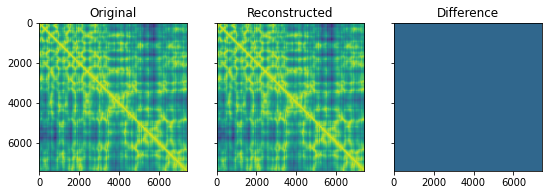

In [23]:
fig, ax = plt.subplots(1,3,figsize=(9, 3), sharey=True)
cmap = plt.get_cmap("viridis_r")

ax[0].set_title("Original")
ax[0].imshow(dist_mat, cmap="viridis_r")
ax[1].set_title("Reconstructed")
ax[1].imshow(new_dist_mat, cmap="viridis_r")
ax[2].set_title("Difference")
ax[2].imshow(delta_dist, cmap="viridis_r")


print("Diffs: max = {0} and min {1}".format(np.amax(delta_dist.numpy()),
                                            np.amin(delta_dist.numpy()) ))

In [27]:
# save pdb file and check manually here: 
# https://molstar.org/viewer/
buffer_save = mdtraj.load("data/1h22_protein_chain_1.pdb")
buffer_save.xyz = pred_mod.T[None, :, :]
buffer_save.save("data/save_to_check.pdb")

In [28]:
# save pdb file and check manually here: 
# https://molstar.org/viewer/
buffer_save = mdtraj.load("data/1h22_protein_chain_1.pdb")
buffer_save.xyz = prot_mod.T[None, :, :]
buffer_save.save("data/save_to_check_base.pdb")

Legend:
* blue/purple: reference
* green/orange: our reconstruction

Comments: only small blue detail on the left. increase match by decreasing tolerance

<img src="data/comparison.png">